# Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from ipywidgets import FloatProgress
from matplotlib.colors import ListedColormap
from sklearn import ensemble, cross_validation, learning_curve, metrics, multiclass, preprocessing, grid_search
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def tolerant_score(expected, predicted):
    score = 0.
    for one, two in zip(expected, predicted):
        for xx, yy in zip(one, two):
            if xx == yy:
                score += 0.33
    return score / len(expected)

In [3]:
def plot_confusion_matrix(matrix, labels):
    pylab.clf()
    pylab.figure(figsize = (7, 7))
    pylab.matshow(matrix, fignum=False, cmap='Blues', vmin=0., vmax=1.0)
    
    ax = pylab.axes()
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    
    pylab.title('Confusion matrix')
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    
    pylab.show()

In [4]:
def plot_accuracy(optimizer, count):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.subplot(1, 2, count)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.title('Best C = %.2f' % optimizer.best_params_['C'])

In [5]:
def plot_forest(X_train, y_train, X_test, y_test, model):
    plt.figure(figsize = (16, 6))
    h = 0.02

    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    pyplot.subplot(1,2,1)
    plt.title('RandomForest on train')
    plt.pcolormesh(xx, yy, Z, cmap = ListedColormap(['lightcoral', 'lightblue', 'lightyellow']))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y, cmap=ListedColormap(['red', 'blue', 'yellow']), s=60, alpha = 0.5)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    
    pyplot.subplot(1,2,2)
    plt.title('RandomForest on test')
    plt.pcolormesh(xx, yy, Z, cmap = ListedColormap(['lightcoral', 'lightblue', 'lightyellow']))
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y, cmap=ListedColormap(['red', 'blue', 'yellow']), s=60, alpha = 0.5)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

In [6]:
data = pd.read_csv('thebestclasses.csv', index_col='Unnamed: 0')

X = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
y = data['Label']

pia_border = np.where(data['Label'] == 0)[0][-1:][0]
vio_border = np.where(data['Label'] == 1)[0][-1:][0]

pia_data = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
pia_data['Label'] = np.hstack([np.ones(pia_border), np.zeros(len(data) - pia_border)])
X_pia = pia_data.drop('Label', axis = 1)
y_pia = pia_data['Label']

vio_data = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
vio_data['Label'] = np.hstack([np.zeros(pia_border), np.ones(vio_border - pia_border),
                               np.zeros(len(data) - vio_border)])
X_vio = vio_data.drop('Label', axis = 1)
y_vio = vio_data['Label']

gac_data = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
gac_data['Label'] = np.hstack([np.zeros(vio_border), np.ones(len(data) - vio_border)])
X_tru = gac_data.drop('Label', axis = 1)
y_tru = gac_data['Label']

In [7]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.3, stratify = y, random_state=0)

sc = preprocessing.StandardScaler()

X_train = preprocessing.StandardScaler.fit_transform(sc, X_train)
X_test = preprocessing.StandardScaler.transform(sc, X_test)

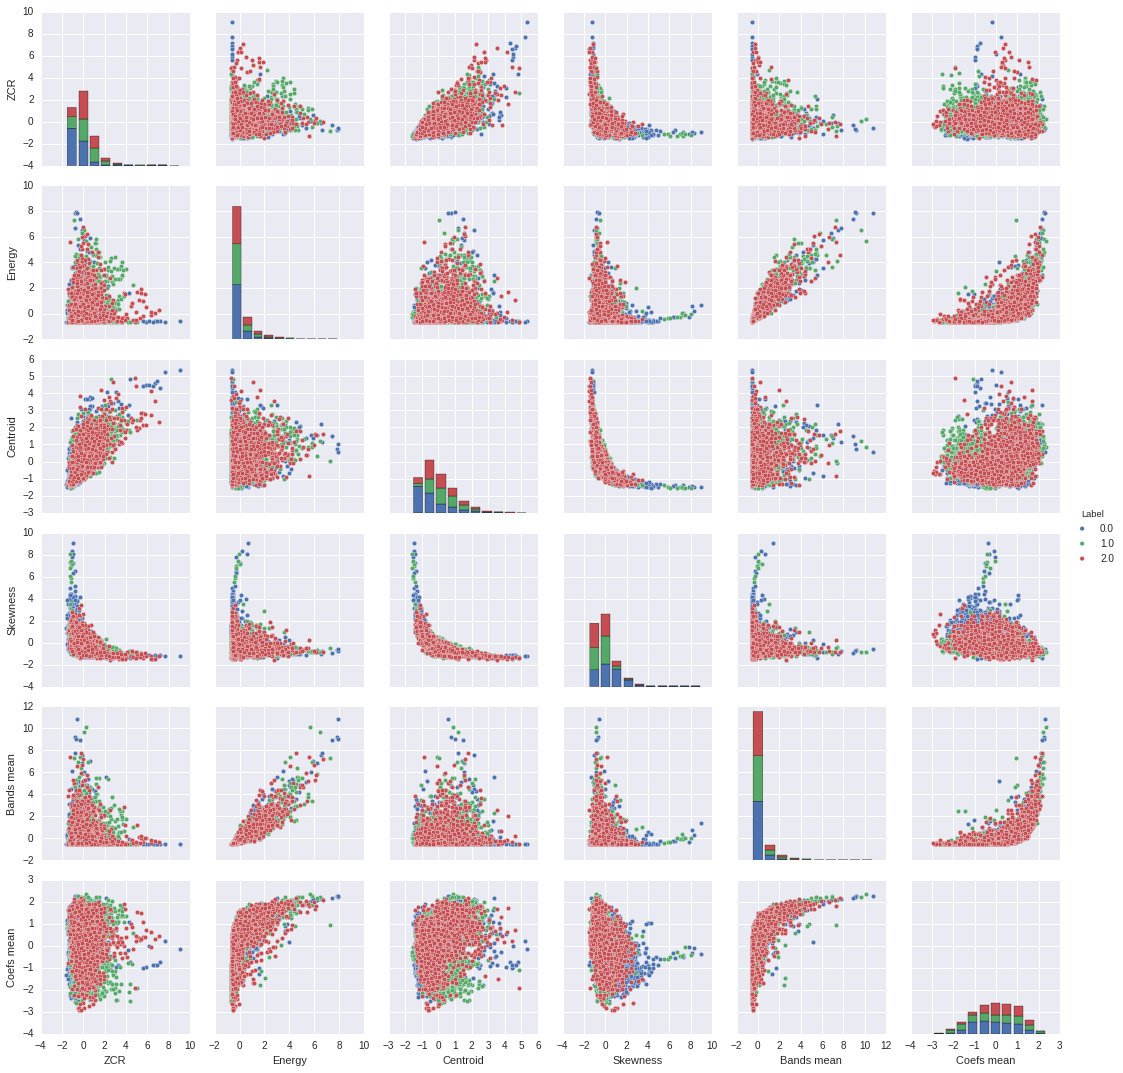

In [8]:
view = pd.DataFrame(data = preprocessing.StandardScaler.fit_transform(sc, data.drop('Label', axis = 1)),
                           columns = [x for subarr in [['ZCR'],
                                                      ['Energy'],
                                                      ['Centroid'],
                                                      ['Variance'],
                                                      ['Skewness'],
                                                      ['Kurtosis'],
                                                      ['MFCC%d' % i for i in xrange(53)],
                                                      ['Bands mean'],
                                                      ['Coefs mean']] for x in subarr])
view['Label'] = y
pairgrid = sns.pairplot(view, hue = 'Label', vars = ['ZCR', 'Energy', 'Centroid', 'Skewness', 'Bands mean', 'Coefs mean'])
pairgrid.savefig('pairplotscaled.png')

In [35]:
correlating = np.where(view.corr()['Label'] >= 0.15)[0]
print view.corr()['Label'][correlating]

ZCR         0.297314
Centroid    0.194620
MFCC15      0.163670
MFCC16      0.207873
MFCC18      0.167715
MFCC19      0.170802
MFCC21      0.163991
MFCC40      0.274181
MFCC43      0.159239
Label       1.000000
Name: Label, dtype: float64


$$logloss=−\frac{1}{N}\sum\limits_{i=1}^N \sum\limits_{j=1}^M y_{ij} \log p_{ij}$$

## LogisticRegression

In [9]:
from sklearn.linear_model import LogisticRegression

logit_params = {'C': np.arange(0.01, 1, 0.05),
             'penalty': ['l1', 'l2']}

In [10]:
%%time
estimator = LogisticRegression(random_state=0)
optimizer = grid_search.GridSearchCV(estimator=estimator, param_grid=logit_params, cv=5)

optimizer.fit(X_train, y_train)
score = optimizer.score(X_test, y_test)

print 'Accuracy: %f' % score
print 'LogLoss: %f' % metrics.log_loss(y_test, optimizer.predict_proba(X_test))
print 'Best params: %s' % optimizer.best_params_
print '\nTime elapsed:\n'

Accuracy: 0.665878
LogLoss: 0.833817
Best params: {'penalty': 'l1', 'C': 0.56000000000000005}

Time elapsed:

CPU times: user 1min 14s, sys: 60 ms, total: 1min 14s
Wall time: 1min 14s


In [11]:
coefs = []
for line in optimizer.best_estimator_.coef_.T:
    coefs.append(abs(sum(line)))

print shape(coefs)
zeros = np.where(np.array(coefs) == 0.)
print data.columns[zeros]

(59,)
Index([], dtype='object')


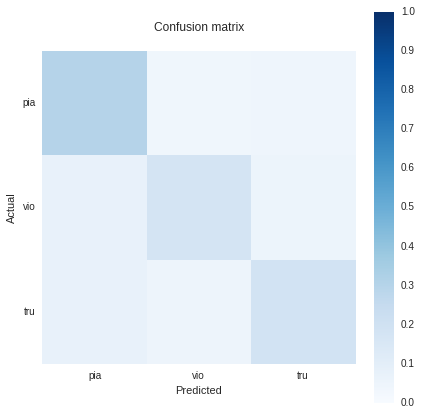

In [12]:
matrix = metrics.confusion_matrix(y_test, optimizer.predict(X_test)) / float(len(y_test))
plot_confusion_matrix(matrix, ['pia', 'vio', 'tru'])

## RandomForest

### Single label

In [13]:
rf = ensemble.RandomForestClassifier(random_state=0)

In [14]:
rf_params = {'n_estimators': range(1, 50, 3),
             'max_depth': range(1, 20, 1),
             'min_samples_leaf': range(1, 10, 1)}

In [15]:
rf_optimizer = grid_search.RandomizedSearchCV(estimator=rf, param_distributions=rf_params, cv=5, random_state=0)

In [16]:
%%time
rf_optimizer.fit(X_train, y_train)

score = rf_optimizer.score(X_test, y_test)
y_proba = rf_optimizer.predict_proba(X_test)
y_pred = rf_optimizer.predict(X_test)

print 'Accuracy: %f' % score
print 'LogLoss: %f' % metrics.log_loss(y_test, y_proba)
print 'Best params: %s' % rf_optimizer.best_params_
print '\nTime elapsed:\n'

Accuracy: 0.765228
LogLoss: 0.625462
Best params: {'n_estimators': 43, 'max_depth': 12, 'min_samples_leaf': 3}

Time elapsed:

CPU times: user 24 s, sys: 36 ms, total: 24 s
Wall time: 24.1 s


In [17]:
matches = 0

for one, two in zip(y_test[:20], y_pred[:20]):
    print int(one), int(two), one == two

for one, two in zip(y_test, y_pred):
    if one == two:
        matches += 1

print 'Matches: %d\nNon-matches: %d' % (matches, len(y_test) - matches)

2 2 True
1 1 True
1 1 True
2 2 True
2 0 False
1 1 True
2 0 False
1 1 True
2 2 True
0 0 True
1 1 True
0 0 True
1 0 False
1 1 True
0 1 False
0 2 False
0 0 True
0 0 True
1 1 True
2 2 True
Matches: 1294
Non-matches: 397


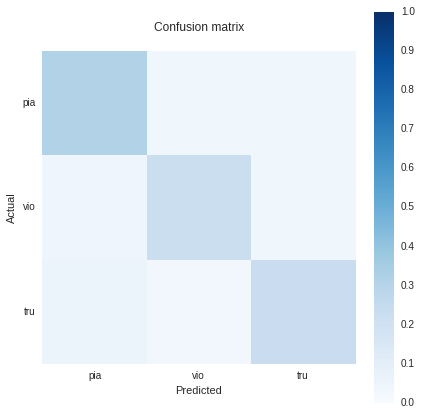

In [18]:
matrix = metrics.confusion_matrix(y_test, y_pred) / float(len(y_test))
plot_confusion_matrix(matrix, ['pia', 'vio', 'tru'])

Predicting probabilities might also be a good idea

### Multilabel

The data might not be multi-label, but let's give it a try. Unsurprisingly, ```sklearn``` already has multi-label classifier.

In [19]:
%%time
Y_train = preprocessing.MultiLabelBinarizer().fit_transform([[y] for y in y_train])
Y_test = preprocessing.MultiLabelBinarizer().fit_transform([[y] for y in y_test])

base = ensemble.RandomForestClassifier(random_state=0)
ml_optimizer = grid_search.RandomizedSearchCV(estimator=base, param_distributions=rf_params, cv=5, random_state=0)

clf = multiclass.OneVsRestClassifier(ml_optimizer)
clf.fit(X_train, Y_train)

score = clf.score(X_test, Y_test)
tolerant = tolerant_score(Y_test, clf.predict(X_test))

print 'Exact matches accuracy: %f' % score
print 'Tolerant matches accuracy: %f' % tolerant
print '\nTime elapsed:\n'

Exact matches accuracy: 0.667652
Tolerant matches accuracy: 0.845979

Time elapsed:

CPU times: user 1min 8s, sys: 224 ms, total: 1min 8s
Wall time: 1min 8s


In [20]:
print 'Expect    Real  Equal'
for one, two in zip(Y_test, clf.predict(X_test)[:20]):
    print one, two, (one == two).all()
    
trues = 0
zeros = 0
for one, two in zip(Y_test, clf.predict(X_test)):
    if (one == two).all():
        trues += 1
    if (two == 0).all():
        zeros += 1

print 'Matches: %d\nNon-matches: %d\nFully zero: %d (is %.2f of all)' % (trues,
                                                                         len(Y_test) - trues, zeros,
                                                                         float(zeros) / len(Y_test))

Expect    Real  Equal
[0 0 1] [0 0 0] False
[0 1 0] [0 1 0] True
[0 1 0] [0 1 0] True
[0 0 1] [0 0 1] True
[0 0 1] [0 0 0] False
[0 1 0] [0 1 0] True
[0 0 1] [0 0 0] False
[0 1 0] [0 1 0] True
[0 0 1] [0 0 1] True
[1 0 0] [1 0 0] True
[0 1 0] [0 1 0] True
[1 0 0] [1 0 0] True
[0 1 0] [0 0 0] False
[0 1 0] [0 1 0] True
[1 0 0] [0 1 0] False
[1 0 0] [0 0 1] False
[1 0 0] [1 0 0] True
[1 0 0] [1 0 0] True
[0 1 0] [0 0 0] False
[0 0 1] [0 0 1] True
Matches: 1129
Non-matches: 562
Fully zero: 347 (is 0.21 of all)


The quality is poor due to one main reason — the metric is strict and only allows exact match of prediction to test label. The data might also not be multi-label, so we are mistaken a lot. Also, in 30% of test data the algorithm doesn't know what to answer — I think it deals with dropouts.

## XGBoost

### Single label

In [21]:
xgb_estimator = xgb.XGBClassifier(seed = 0)

In [22]:
xgb_params = {'n_estimators': range(1, 50, 3),
              'max_depth': range(1, 20, 1)}

In [23]:
xgb_optimizer = grid_search.RandomizedSearchCV(estimator=xgb_estimator, param_distributions=xgb_params, cv=5, random_state=0)

In [24]:
%%time
xgb_optimizer.fit(X_train, y_train)

CPU times: user 2min 56s, sys: 476 ms, total: 2min 57s
Wall time: 1min 38s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          scoring=None, verbose=0)

In [25]:
score = xgb_optimizer.score(X_test, y_test)

print 'Accuracy: %f' % score
print 'LogLoss: %f' % metrics.log_loss(y_test, xgb_optimizer.predict_proba(X_test))
print 'Best params: %s' % xgb_optimizer.best_params_

Accuracy: 0.786517
LogLoss: 0.531255
Best params: {'n_estimators': 40, 'max_depth': 15}


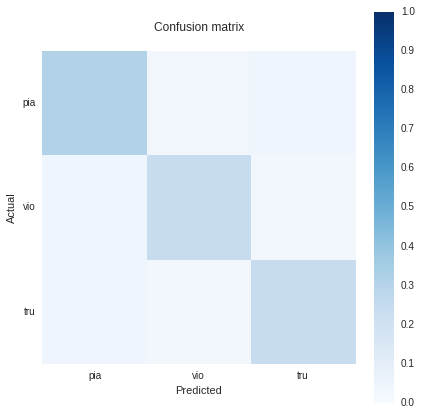

In [26]:
matrix = metrics.confusion_matrix(y_test, xgb_optimizer.predict(X_test)) / float(len(y_test))
plot_confusion_matrix(matrix, ['pia', 'vio', 'tru'])

Basically a little better than RandomForest. Won't try multi-label for now.

## SVD
### Somehow